In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math as m

In [2]:
# load data
train_data = pd.read_csv('TrainDigitX.csv')
test_data = pd.read_csv('TestDigitX.csv')
train_data['labels'] = pd.read_csv('TrainDigitY.csv')
test_data['labels'] = pd.read_csv('TestDigitY.csv')

In [3]:
# Checking the number of examples in our training data
len(train_data)

49999

In [4]:
# Checking the number of examples in our test data
len(test_data)

9999

In [5]:
# taking a look at our training data
train_data.head(2)

,0.000000,0.000000.1,0.000000.2,0.000000.3,0.000000.4,0.000000.5,0.000000.6,0.000000.7,0.000000.8,0.000000.9,...,0.000000.609,0.000000.610,0.000000.611,0.000000.612,0.000000.613,0.000000.614,0.000000.615,0.000000.616,0.000000.617,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


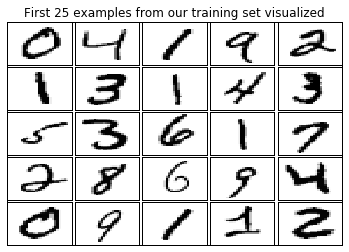

In [6]:
# Visualizing the first 25 images from our training set
fig = plt.figure()
plt.clf()
plt.title('First 25 examples from our training set visualized')
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', 
                    left='off', labelleft='off')

for i in range(25):
    ax = fig.add_subplot(5,5,i+1) 
    image_1 = train_data.loc[i,:][0:784]
    image_1 = image_1.reshape(28,28)
    plt.imshow(image_1, cmap='Greys', interpolation = 'nearest' )
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.show()

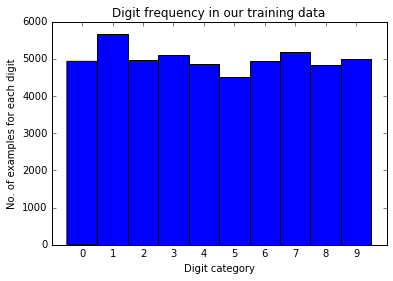

In [7]:
plt.figure()
plt.title('Digit frequency in our training data')
plt.hist(train_data['labels'],bins=np.arange(11)-0.5)
plt.xticks(range(10))
plt.xlim([-1, 10])
plt.ylabel('No. of examples for each digit')
plt.xlabel('Digit category')
plt.show()

## Creating Validation set:

In [8]:
# A function for determing the indeces of our examples that will be included in our training and validation data
def get_train_valid_inds(y,train_proportion):
    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    valid_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        valid_inds[value_inds[n:]]=True
    return train_inds,valid_inds

In [9]:
train_inds, valid_inds = get_train_valid_inds(train_data['labels'], 0.8)

In [10]:
# Separating our previous training data into our new training data on which we will train our models and the validation data
# which we will use later to determine the best values for the model parameters
train_data_new = train_data.loc[train_inds]
validation_data = train_data.loc[valid_inds]

In [11]:
len(train_data_new)

39995

In [12]:
len(validation_data)

10004

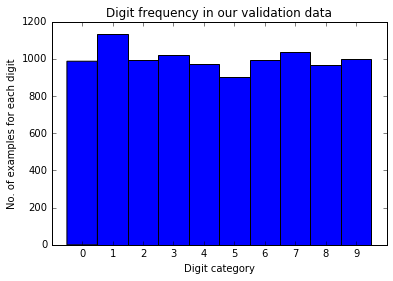

In [13]:
plt.figure()
plt.title('Digit frequency in our validation data')
plt.hist(validation_data['labels'],bins=np.arange(11)-0.5)
plt.xticks(range(10))
plt.xlim([-1, 10])
plt.ylabel('No. of examples for each digit')
plt.xlabel('Digit category')
plt.show()
# From the plot below we can see that the structure of the data in a validation set is preserved and that all the 
# classes are represented almost equally

# Neural network with one hidden layer

In [67]:
# Defining the neural network parameters:

input_layer_size = 784;        # 28x28 Input Images of Digits
hidden_layer_size = 100;       # num of hidden units
num_labels = 10;               # 10 labels, digits from 0 to 9

X_train = train_data_new.drop(['labels'], axis=1)
X_train = np.array(X_train)
Y_train = np.array(train_data_new['labels'])
X_validate = np.array(validation_data.drop(['labels'], axis=1))
Y_validate = np.array(validation_data['labels'])
num_training_examples = len(X_train)
num_validation_examples = len(X_validate)
mini_batch_size = 1    # the stochastic gradient descent with batch size of 1 is being used

In [68]:
# Function for Initalizing Weights

def Weights_Initialization(input_layer_size, hidden_layer_size, num_labels):
    r1 = m.sqrt(6/float(input_layer_size+1+hidden_layer_size))
    r2 = m.sqrt(6/float(hidden_layer_size+1+num_labels))
    np.random.seed(0)
    Theta_1 = (np.random.rand(hidden_layer_size, input_layer_size)*2*r1)-r1
    b1 = (np.random.rand(hidden_layer_size)*2*r1)-r1
    Theta_2 = (np.random.rand(num_labels, hidden_layer_size)*2*r2)-r2
    b2 = (np.random.rand(num_labels)*2*r2)-r2
    return Theta_1, Theta_2, b1, b2

In [69]:
# Defining a function that we will call later whenever we need to do a feedforward step

def FeedforwardCalculation(X, Theta_1, Theta_2, b1, b2):
    z1 = np.dot( X, Theta_1.T) + b1
    a2 = np.tanh(z1)
    z2 = np.dot(a2, Theta_2.T) + b2
    exponentials = np.exp(z2)
    y_predicted = exponentials / np.sum(exponentials, axis=1, keepdims=True)
          
    return a2, y_predicted


In [70]:
# Cross entropy loss is used
def Loss_Calculation(Y_predicted, Y_real):
    n = len(Y_predicted)
    Loss = 1/float(n)*np.sum(-np.log(Y_predicted[range(n),Y_real]))
    return Loss

In [71]:
def Accuracy(Y_predicted, Y_real):
    n = len(Y_predicted)
    count = np.sum(Y_predicted.T == Y_real)
    Accuracy = float(count)/n
    Error = 1-Accuracy
    return Accuracy, Error

In [72]:
def BackpropagationCalculation(Y_predicted, Y_real, Theta_1,Theta_2,b1, b2, X, a2, learning_rate):
    delta3 = Y_predicted
    delta3[:,Y_real] = delta3[:,Y_real]-1
    delta2 = np.dot(delta3, Theta_2 )*(1 - a2**2)
    
    DELTA_2 = np.dot(a2.T, delta3)
    DELTA_1 = np.dot(X.T, delta2)
    DELTA_b2 = np.sum(delta3, axis=0, keepdims=True)
    DELTA_b1 = np.sum(delta2, axis=0)
    
    # Updating both weights (Theta_1 and Theta_2) and biases (b1 and b2)
    Theta_1 = Theta_1 - learning_rate * DELTA_1.T
    Theta_2 = Theta_2 - learning_rate * DELTA_2.T
    b1 = b1 - learning_rate * DELTA_b1
    b2 = b2 - learning_rate * DELTA_b2
   
    return Theta_1, Theta_2, b1, b2

In [73]:
def Building_the_model(input_layer_size,hidden_layer_size, num_labels, learning_rate, X_train, Y_train, X_validate,
                       Y_validate, mini_batch_size, num_validation_examples, max_num_epochs):
    
    # Initializing weights
    Theta_1, Theta_2, b1, b2 = Weights_Initialization(input_layer_size, hidden_layer_size, num_labels)
   
    # Applying Stochastic Gradient Descent with mini batch size of 1:
    epoch_num = 0
    validation_error = []
    loss_on_validation_set = []
    training_error = []
    
    while epoch_num <= max_num_epochs:
        
        # Compute an error and loss on validation set:
        # First we need to do a feedforward step using features in validation set:
        
        a2_valid, Y_predicted_valid = FeedforwardCalculation(X_validate, Theta_1, Theta_2, b1, b2)
        Y_pred_output_valid = np.argsort(Y_predicted_valid, axis = 1)[:,-1]
        Y_pred_output_valid = Y_pred_output_valid.reshape(-1,1)
        
        Accuracy_valid, Error_valid = Accuracy(Y_pred_output_valid, Y_validate)
        loss_valid = Loss_Calculation(Y_predicted_valid, Y_validate)
        
        validation_error.append(Error_valid)
        loss_on_validation_set.append(loss_valid)
        
        if epoch_num % 5 == 0:
            print epoch_num, Error_valid, loss_valid
            
        # Do a feedforward step on our training data to obtain error and accuracy for our training data for each epoch
        a2, Y_predicted_train = FeedforwardCalculation(X_train, Theta_1, Theta_2, b1, b2)
        Y_pred_output_train = np.argsort(Y_predicted_train, axis = 1)[:,-1]
        Y_pred_output_train = Y_pred_output_train.reshape(-1,1)
            
        # Calculcate Accuracy on our training data:
        Accuracy_train, Error_train = Accuracy(Y_pred_output_train, Y_train)
        training_error.append(Error_train)
        
        # Before every epoch shuffle training data randomly
        shuffle_index = np.arange(np.shape(X_train)[0])
        np.random.shuffle(shuffle_index)
        
        # do an actual training using our training data using stochastic gradient descent with batch size of 1
        for i in range(num_training_examples):
            X = (X_train[shuffle_index[i], :]).reshape(1,len(X_train[shuffle_index[i], :]))

            # Do a feedforward step
            a2, Y_predicted = FeedforwardCalculation(X, Theta_1, Theta_2, b1, b2)
                        
            # Do a backprop step
            Theta_1, Theta_2, b1, b2 = BackpropagationCalculation(Y_predicted, Y_train[shuffle_index[i]], Theta_1, 
                                                                  Theta_2,b1, b2, X, a2, learning_rate)
            
        epoch_num += 1

    return Theta_1, Theta_2, b1, b2, epoch_num, validation_error, loss_on_validation_set, training_error

In [33]:
learning_rate = 0.003 # Fixing the learning rate

# Trying out dufferent hidden layer sizes:
hidden_layer_sizes = [5,15,40,100]

loss_validation_dict = {}

for hls in hidden_layer_sizes:

    Theta_1, Theta_2, b1, b2, epoch_num, validation_error, loss_on_validation_set, training_error = \
                                                            Building_the_model(input_layer_size,hls, num_labels, 
                                                            learning_rate,X_train, Y_train,X_validate,Y_validate, 
                                                            mini_batch_size, num_validation_examples,40)
            
    loss_validation_dict [ str(hls)] = loss_on_validation_set   

0 0.923430627749 2.38322924869
5 0.133246701319 0.472752395314
10 0.125349860056 0.447923990757
15 0.128648540584 0.465689392662
20 0.131347461016 0.470755812118
25 0.134146341463 0.479312306181
30 0.12924830068 0.463909965822
35 0.13274690124 0.475345566711
40 0.130347860856 0.468551568336
0 0.90693722511 2.41835110918
5 0.0687724910036 0.231306724416
10 0.0597760895642 0.207286857137
15 0.0603758496601 0.208163203614
20 0.0566773290684 0.202413937247
25 0.0582766893243 0.208721541668
30 0.0607756897241 0.216282236581
35 0.0586765293882 0.215626244392
40 0.0605757696921 0.224292714397
0 0.913834466214 2.43530311148
5 0.0487804878049 0.160388472561
10 0.0415833666533 0.1396022337
15 0.0401839264294 0.130734936352
20 0.0380847660936 0.131979671722
25 0.0386845261895 0.131923314666
30 0.0392842862855 0.136912824961
35 0.0396841263495 0.141604652193
40 0.0399840063974 0.140599823659
0 0.927928828469 2.43742334209
5 0.0384846061575 0.135752393743
10 0.0302878848461 0.1069154117
15 0.028988

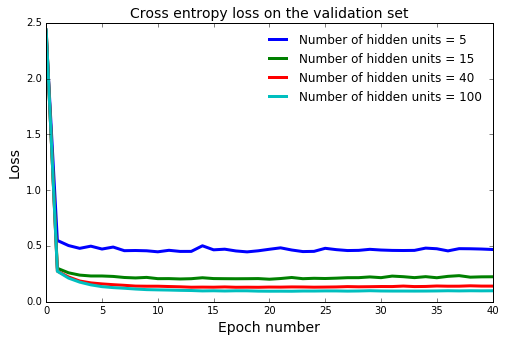

In [40]:
plt.figure(figsize=(8,5))
plt.clf()
for hls in hidden_layer_sizes:
    plt.plot(range(0,epoch_num), loss_validation_dict[ str(hls) ],'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(0,40)
plt.legend(['Number of hidden units = 5','Number of hidden units = 15','Number of hidden units = 40',
            'Number of hidden units = 100'],frameon = False)
plt.title('Cross entropy loss on the validation set',fontsize = 14)

plt.show()

In [41]:
hidden_layer_size = 100  # Fixing hidden layer size

# Trying out dufferent learning rates:
learning_rates = [0.0003, 0.003, 0.03, 0.1]

loss_validation_dict = {}

for lr in learning_rates:
    print lr
    Theta_1, Theta_2, b1, b2, epoch_num, validation_error, loss_on_validation_set, training_error = \
                                                    Building_the_model(input_layer_size,hidden_layer_size, 
                                                    num_labels, lr, X_train, Y_train,X_validate,
                                                    Y_validate, mini_batch_size, num_validation_examples,40)
            
    loss_validation_dict [ str(lr)] = loss_on_validation_set

0.0003
0 0.927928828469 2.43742334209
5 0.0914634146341 0.314302538006
10 0.0761695321871 0.263245028392
15 0.0668732506997 0.228236461765
20 0.0592762894842 0.202761546668
25 0.0539784086365 0.182410573487
30 0.0487804878049 0.166769994313
35 0.0450819672131 0.154652971372
40 0.0424830067973 0.145676517714
0.003
0 0.927928828469 2.43742334209
5 0.0384846061575 0.135752393743
10 0.0302878848461 0.1069154117
15 0.0289884046381 0.0989085738081
20 0.0267892842863 0.0949335949303
25 0.0273890443822 0.0976027277617
30 0.0268892443023 0.0970320867827
35 0.0267892842863 0.0974136200837
40 0.0266893242703 0.098819045952
0.03
0 0.927928828469 2.43742334209
5 0.046881247501 0.200131135116
10 0.0376849260296 0.165297141769
15 0.0357856857257 0.179761255735
20 0.0338864454218 0.171763557182
25 0.0297880847661 0.159852903642
30 0.0297880847661 0.155570224515
35 0.0293882447021 0.15664928728
40 0.0294882047181 0.157707521775
0.1
0 0.927928828469 2.43742334209
5 0.15343862455 1.36972245298
10 0.12914

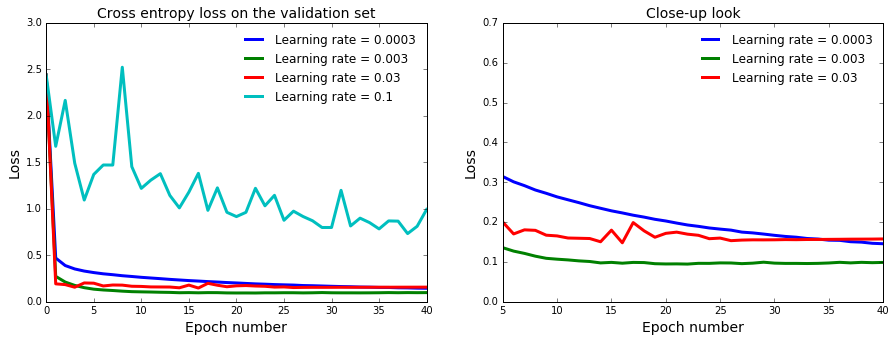

In [49]:
plt.figure(figsize=(15,5))
plt.clf()
plt.subplot(1,2,1)
for lr in learning_rates:
    plt.plot(range(0,epoch_num), loss_validation_dict[ str(lr) ],'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(0,40)
plt.legend(['Learning rate = 0.0003','Learning rate = 0.003','Learning rate = 0.03',
           'Learning rate = 0.1'],frameon = False)
plt.title('Cross entropy loss on the validation set',fontsize = 14)

plt.subplot(1,2,2)
for lr in learning_rates:
    plt.plot(range(0,epoch_num), loss_validation_dict[ str(lr) ],linestyle = '-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(5,40)
plt.ylim(0.0,0.7)
plt.legend(['Learning rate = 0.0003','Learning rate = 0.003','Learning rate = 0.03'],frameon = False)
plt.title('Close-up look',fontsize = 14)
plt.show()

From the figure above, it seems like the optimal rate is 0.003 and that learning saturates after only 20 epochs. So we will 
use this value for our learning rate and train our final model for 20 epochs and see how it performs.

In [74]:
#Running our final model with 100 hidden layers and learning rate of 0.003 to obtain needed weights:
learning_rate = 0.003
hidden_layer_size = 100
Theta_1, Theta_2, b1, b2, epoch_num, validation_error, loss_on_validation_set, training_error = \
                                                                    Building_the_model(input_layer_size,hidden_layer_size, 
                                                                    num_labels,learning_rate,X_train, Y_train,X_validate,
                                                                    Y_validate,mini_batch_size, num_validation_examples,20)

0 0.926729308277 2.43442203208
5 0.0399840063974 0.137904549558
10 0.031487405038 0.102479837591
15 0.0284886045582 0.0921947434329
20 0.0283886445422 0.0916842038698


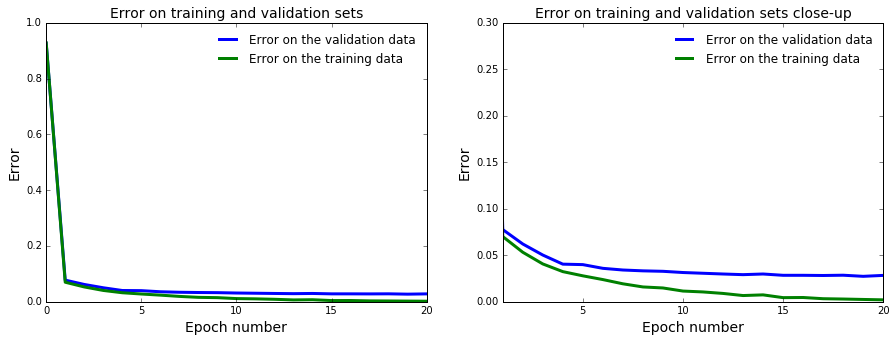

In [76]:
plt.figure(figsize=(15,5))
plt.clf()
plt.subplot(1,2,1)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(0,20)
plt.ylim(0.,1.)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets',fontsize = 14)

plt.subplot(1,2,2)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(1,20)
plt.ylim(0,0.3)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets close-up',fontsize = 14)
plt.show()

In [77]:
X_test = np.array(test_data.drop(['labels'], axis=1))
Y_test = np.array(test_data['labels'])
num_test_examples = len(X_test)

In [78]:
# Doing feedforward step for our test data to obtain predicted labels for our test data and then accuracy of our model
a2_test, Y_predicted_test = FeedforwardCalculation(X_test, Theta_1, Theta_2, b1, b2)
Y_pred_output_test = np.argsort(Y_predicted_test, axis = 1)[:,-1]
Y_pred_output_test = Y_pred_output_test.reshape(-1,1)
        
Accuracy_test, Error_test = Accuracy(Y_pred_output_test, Y_test)        
print('Accuracy of the model on the test data is %.2f%% ' % (100*Accuracy_test),
      'Error on the test data is %.2f%%' % (100*Error_test))              

('Accuracy of the model on the test data is 97.52% ', 'Error on the test data is 2.48%')


## Building a neural network with two hidden layers:

In [50]:
# Defining the neural network parameters:

learning_rate = 0.003
# Fixing the learning rate
input_layer_size = 784;       # 28x28 Input Images of Digits
hidden_layer_size1 = 100;      # num of hidden units in the first hidden layer
hidden_layer_size2 = 100;      # num of hidden units in the second hidden layer
num_labels = 10;              # 10 labels, digits ranging from 0 to 9

X_train = train_data_new.drop(['labels'], axis=1)
X_train = np.array(X_train)
Y_train = np.array(train_data_new['labels'])
X_validate = np.array(validation_data.drop(['labels'], axis=1))
Y_validate = np.array(validation_data['labels'])
num_training_examples = len(X_train)
num_validation_examples = len(X_validate)
mini_batch_size = 1           # the stochastic gradient descent with batch size of 1 is being used

In [51]:
# Initalizing Weights for our second model

def Weights_Initialization2(input_layer_size, hidden_layer_size1,hiden_layer_size2, num_labels):
    r1 = m.sqrt(6/float(input_layer_size+1+hidden_layer_size1))
    r2 = m.sqrt(6/float(hidden_layer_size1+1+hidden_layer_size2))
    r3 =m.sqrt(6/float(hidden_layer_size2+1+num_labels))
    np.random.seed(0)
    Theta_1 = (np.random.rand(hidden_layer_size1, input_layer_size)*2*r1)-r1
    b1 = (np.random.rand(hidden_layer_size1)*2*r1)-r1
    
    Theta_2 = (np.random.rand(hidden_layer_size2, hidden_layer_size1)*2*r2)-r2
    b2 = (np.random.rand(hidden_layer_size2)*2*r2)-r2
    
    Theta_3 = (np.random.rand(num_labels, hidden_layer_size2)*2*r3)-r3
    b3 = (np.random.rand(num_labels)*2*r3)-r3
    
    return Theta_1, Theta_2, Theta_3, b1, b2, b3

In [52]:
# Defining a function that we will call later whenever we need to do a feedforward step

def FeedforwardCalculation2(X, Theta_1, Theta_2, Theta_3, b1, b2, b3):
    z1 = np.dot( X, Theta_1.T) + b1
    a2 = np.tanh(z1)       # activations values for our first hidden layer
    z2 = np.dot(a2, Theta_2.T) + b2
    a3 = np.tanh(z2)       # activations values for our second hidden layer
    z3 = np.dot(a3, Theta_3.T) + b3
    exponentials = np.exp(z3)
    y_predicted = exponentials / np.sum(exponentials, axis=1, keepdims=True) # predicted output
          
    return a2, a3, y_predicted

In [53]:
# Cross entropy loss is used
def Loss_Calculation(Y_predicted, Y_real):
    n = len(Y_predicted)
    Loss = 1/float(n)*np.sum(-np.log(Y_predicted[range(n),Y_real]))
    return Loss

In [54]:
def Accuracy(Y_predicted, Y_real):
    n = len(Y_predicted)
    count = np.sum(Y_predicted.T == Y_real)
    Accuracy = float(count)/n
    Error = 1-Accuracy
    return Accuracy, Error

In [55]:
def BackpropagationCalculation2(Y_predicted, Y_real, Theta_1,Theta_2,Theta_3,b1, b2, b3, X, a2,a3, learning_rate):
    delta4 = Y_predicted
    delta4[:,Y_real] = delta4[:,Y_real]-1
    
    delta3 = np.dot(delta4, Theta_3 )*(1 - a3**2)
    delta2 = np.dot(delta3, Theta_2 )*(1 - a2**2)
    
    DELTA_3 = np.dot(a3.T, delta4)
    DELTA_2 = np.dot(a2.T, delta3)
    DELTA_1 = np.dot(X.T, delta2)
    DELTA_b3 = np.sum(delta4, axis=0, keepdims=True)
    DELTA_b2 = np.sum(delta3, axis=0, keepdims=True)
    DELTA_b1 = np.sum(delta2, axis=0)
    
    # Updating both weights (Theta_1, Theta_2 and Theta_3) and biases (b1. b2 and b3)
    Theta_1 = Theta_1 - learning_rate * DELTA_1.T
    Theta_2 = Theta_2 - learning_rate * DELTA_2.T
    Theta_3 = Theta_3 - learning_rate * DELTA_3.T
    b1 = b1 - learning_rate * DELTA_b1
    b2 = b2 - learning_rate * DELTA_b2
    b3 = b3 - learning_rate * DELTA_b3
    
    return Theta_1, Theta_2, Theta_3, b1, b2, b3

In [56]:
def Building_the_model2(input_layer_size,hidden_layer_size1, hidden_layer_size2, num_labels, learning_rate, X_train, Y_train, 
                        X_validate, Y_validate, mini_batch_size, num_validation_examples, max_num_epochs):
    
    # Initializing weights
    Theta_1, Theta_2, Theta_3, b1, b2, b3 = Weights_Initialization2(input_layer_size, hidden_layer_size1, hidden_layer_size2,
                                                                   num_labels)
   
    # Applying Stochastic Gradient Descent with mini batch size of 1:
    epoch_num = 0
    validation_error = []
    loss_on_validation_set =[] 
    training_error = []
    
    while epoch_num <=max_num_epochs:
        
        # Compute an error and a loss on validation set:
        # First we need to do a feedforward step using features in validation set:
        
        a2_valid, a3_valid, Y_predicted_valid = FeedforwardCalculation2(X_validate, Theta_1, Theta_2, Theta_3, b1, b2, b3)
        Y_pred_output_valid = np.argsort(Y_predicted_valid, axis = 1)[:,-1]
        Y_pred_output_valid = Y_pred_output_valid.reshape(-1,1)
        
        Accuracy_valid, Error_valid = Accuracy(Y_pred_output_valid, Y_validate)
        loss_valid = Loss_Calculation(Y_predicted_valid, Y_validate)

        validation_error.append(Error_valid)
        loss_on_validation_set.append(loss_valid)

        if epoch_num % 5 == 0:
            print epoch_num,Error_valid,loss_valid
        
        # Do a feedforward step on our training data to obtain error and accuracy for our training data for each epoch
        a2, a3, Y_predicted_train = FeedforwardCalculation2(X_train, Theta_1, Theta_2, Theta_3, b1, b2, b3)
        Y_pred_output_train = np.argsort(Y_predicted_train, axis = 1)[:,-1]
        Y_pred_output_train = Y_pred_output_train.reshape(-1,1)
            
        # Calculcate Accuracy on our training data:
        Accuracy_train, Error_train = Accuracy(Y_pred_output_train, Y_train)
        training_error.append(Error_train)

        # Before every epoch shuffle training data randomly
        shuffle_index = np.arange(np.shape(X_train)[0])
        np.random.shuffle(shuffle_index)      

        # do an actual training using our training data using stochastic gradient descent with batch size of 1
        for i in range(num_training_examples):
            X = (X_train[shuffle_index[i], :]).reshape(1,len(X_train[shuffle_index[i], :]))

            # Do a feedforward step
            a2, a3, Y_predicted = FeedforwardCalculation2(X, Theta_1, Theta_2, Theta_3, b1, b2, b3)
                        
            # Do a backprop step
            Theta_1, Theta_2, Theta_3, b1, b2, b3 = BackpropagationCalculation2(Y_predicted, Y_train[shuffle_index[i]], Theta_1, 
                                                                                Theta_2, Theta_3, b1, b2, b3,X, a2, a3, 
                                                                                learning_rate)
            
        epoch_num += 1
    
    return Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num, validation_error, loss_on_validation_set, training_error

In [62]:
# Running our final model with 2 hidden layers of sizes 15 and 10 respectively and learning rate of 0.003 to obtain 
# needed weights:

Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num, validation_error, loss_on_validation_set, training_error = \
                                                            Building_the_model2(input_layer_size,hidden_layer_size1, 
                                                            hidden_layer_size2, num_labels,learning_rate,X_train, Y_train,
                                                            X_validate,Y_validate, mini_batch_size, num_validation_examples,50)

0 0.889044382247 2.41488498876
5 0.0347860855658 0.108298388003
10 0.0277888844462 0.092921546539
15 0.0273890443822 0.0960690169404
20 0.0253898440624 0.0940059715158
25 0.0257896841263 0.0978128939758
30 0.0251899240304 0.100700775567
35 0.0248900439824 0.101295455376
40 0.0247900839664 0.104281147919
45 0.0249900039984 0.104992709392
50 0.0249900039984 0.107445233718


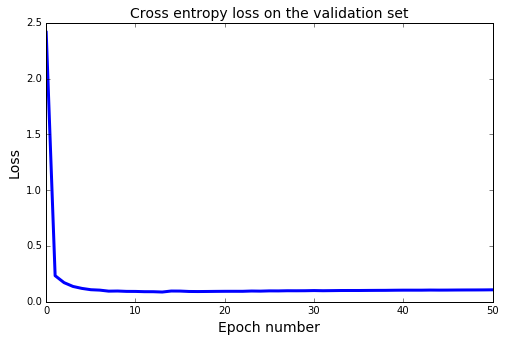

In [63]:
plt.figure(figsize=(8,5))
plt.clf()
plt.plot(range(0,epoch_num), loss_on_validation_set,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.xlim(0,50)
plt.title('Cross entropy loss on the validation set',fontsize = 14)

In [64]:
# Running our final model with 2 hidden layers of sizes 15 and 10 respectively and learning rate of 0.003 to obtain 
# needed weights:

Theta_1, Theta_2, Theta_3, b1, b2, b3, epoch_num, validation_error, loss_on_validation_set, training_error = \
                                                            Building_the_model2(input_layer_size,hidden_layer_size1, 
                                                            hidden_layer_size2, num_labels,learning_rate,X_train, Y_train,
                                                            X_validate,Y_validate, mini_batch_size, num_validation_examples,20)

0 0.889044382247 2.41488498876
5 0.0347860855658 0.108298388003
10 0.0277888844462 0.092921546539
15 0.0273890443822 0.0960690169404
20 0.0253898440624 0.0940059715158


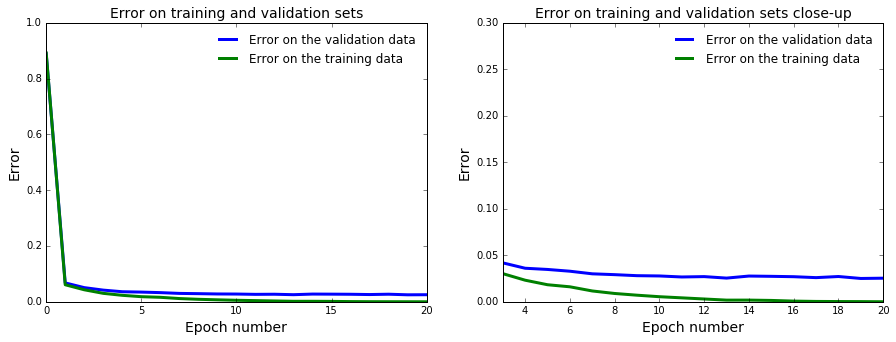

In [65]:
plt.figure(figsize=(15,5))
plt.clf()
plt.subplot(1,2,1)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(0,20)
plt.ylim(0.,1.)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets',fontsize = 14)

plt.subplot(1,2,2)
plt.plot(range(0,epoch_num), validation_error,'-',lw=3)
plt.plot(range(0,epoch_num), training_error,'-',lw=3)
plt.xlabel('Epoch number',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xlim(3,20)
plt.ylim(0,0.3)
plt.legend(['Error on the validation data','Error on the training data'],frameon = False)
plt.title('Error on training and validation sets close-up',fontsize = 14)
plt.show()

In [66]:
# Doing feedforward step for our test data to obtain predicted labels for our test data and then accuracy of our model
a2_test, a3_test, Y_predicted_test = FeedforwardCalculation2(X_test, Theta_1, Theta_2,Theta_3, b1, b2, b3)
Y_pred_output_test = np.argsort(Y_predicted_test, axis = 1)[:,-1]
Y_pred_output_test = Y_pred_output_test.reshape(-1,1)
        
Accuracy_test, Error_test = Accuracy(Y_pred_output_test, Y_test)        
print ('Accuracy of our second model on the test data is %.2f%% ' % (100*Accuracy_test),
      'Error on the test data is %.2f%%' % (100*Error_test))

('Accuracy of our second model on the test data is 97.72% ', 'Error on the test data is 2.28%')


### Conclusion

We trained both models on the same dataset for the same number of epochs. The difference between the models is that we added one
extra hidden layer with 100 units and the end result is that the second model performed better and we have a gain in accuracy of
0.2%. With more complex models the accuracy can be even higher, but because the dataset is not huge, the problem of overfitting 
is more present with more complex models. That's why we will try playing with different regularization techniques in the next 
jupyter notebook.